## Hyperparameter Tuning LSTM Test 5 & 6

### Import Library

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import random as rn
import seaborn as sns
import matplotlib.pyplot as plt
import time

### Pra proses
from sklearn.preprocessing import MinMaxScaler

### Near Miss under sampling
from imblearn.under_sampling import NearMiss 

### Bagi data
from sklearn.model_selection import train_test_split

### Seleksi fitur
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

### Long short term memory (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, Reshape

### metrik pengukuran
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import make_scorer, f1_score

### Tuning Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

### KerasClassifier wrapper
from keras.wrappers.scikit_learn import KerasClassifier

### save model
import joblib

import warnings
warnings.filterwarnings('ignore')

# menampilkan lebih banyak kolom dan baris pada Dataset
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Tipe Dataset #
# ============ #

tipe_dataset = {'dst_port':'uint32','protocol':'uint8','timestamp':'uint64','flow_duration':'int64','tot_fwd_pkts':'uint32','tot_bwd_pkts':'uint32','totlen_fwd_pkts':'uint32','totlen_bwd_pkts':'uint32','fwd_pkt_len_max':'uint16','fwd_pkt_len_min':'uint16',
'fwd_pkt_len_mean':'float32','fwd_pkt_len_std':'float32','bwd_pkt_len_max':'uint16','bwd_pkt_len_min':'uint16','bwd_pkt_len_mean':'float32','bwd_pkt_len_std':'float32','flow_byts_s':'float64','flow_pkts_s':'float64','flow_iat_mean':'float32','flow_iat_std':'float32',
'flow_iat_max':'int64','flow_iat_min':'int64','fwd_iat_tot':'int64','fwd_iat_mean':'float32','fwd_iat_std':'float32','fwd_iat_max':'int64','fwd_iat_min':'int64','bwd_iat_tot':'uint32','bwd_iat_mean':'float32','bwd_iat_std':'float32',
'bwd_iat_max':'uint32','bwd_iat_min':'uint32','fwd_psh_flags':'uint8','bwd_psh_flags':'uint8','fwd_urg_flags':'uint8','bwd_urg_flags':'uint8','fwd_header_len':'uint32','bwd_header_len':'uint32','fwd_pkts_s':'float32','bwd_pkts_s':'float32',
'pkt_len_min':'uint16','pkt_len_max':'uint16','pkt_len_mean':'float32','pkt_len_std':'float32','pkt_len_var':'float32','fin_flag_cnt':'uint8','syn_flag_cnt':'uint8','rst_flag_cnt':'uint8','psh_flag_cnt':'uint8','ack_flag_cnt':'uint8',
'urg_flag_cnt':'uint8','cwe_flag_count':'uint8','ece_flag_cnt':'uint8','down_up_ratio':'uint16','pkt_size_avg':'float32','fwd_seg_size_avg':'float32','bwd_seg_size_avg':'float32','fwd_byts_b_avg':'uint8','fwd_pkts_b_avg':'uint8','fwd_blk_rate_avg':'uint8',
'bwd_byts_b_avg':'uint8','bwd_pkts_b_avg':'uint8','bwd_blk_rate_avg':'uint8','subflow_fwd_pkts':'uint32','subflow_fwd_byts':'uint32','subflow_bwd_pkts':'uint32','subflow_bwd_byts':'uint32','init_fwd_win_byts':'int32','init_bwd_win_byts':'int32','fwd_act_data_pkts':'uint32',
'fwd_seg_size_min':'uint8','active_mean':'float32','active_std':'float32','active_max':'uint32','active_min':'uint32','idle_mean':'float32','idle_std':'float32','idle_max':'uint64','idle_min':'uint64','label':'category',
'flow_id':'object','src_ip':'object','src_port':'float64','dst_ip':'object'}

In [19]:
# Fungsi #
# ====== #

# bagi dataset menjadi variabel input X dan variabel output y
def variabel_input_output(dataset, n, variabel_output):
    X = dataset.iloc[:,:-n]
    y = dataset[variabel_output]
    return X, y

# seleksi fitur metode Chi-squared
def seleksi_fitur(metode, X, y):
    chi2 = SelectKBest(score_func= metode , k=X.shape[1])
    fit = chi2.fit(X, y) 
    return fit

# pemilihan fitur terbaik
def fitur_terbaik(klf, persentase_skor, X, tipe):
    if tipe == 'rf' :
        importances = klf.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]
        labels = X.columns
    
        # mengurutkan fitur berdasarkan skor tertinggi
        skor_fitur = zip(labels, importances)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]

        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        jumlah_persentase = []
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            jumlah_persentase.append(total_skor)
            if total_skor >= sum(skor_diurutkan)*(persentase_skor/100):
                fitur_skor_rendah.append(skor[0])
                 
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Fitur':fitur_diurutkan, 
                                       'Persentase skor': skor_diurutkan/sum(importances)*100,
                                       'jumlah persentase': jumlah_persentase/sum(importances)*100})
        fitur_terpilih.index = np.arange(1,len(fitur_terpilih)+1)                               
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
                
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(importances))], importances)
        plt.xticks([i for i in range(len(importances))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
        
    else :
        # mengurutkan fitur berdasarkan bobot tertinggi
        skor_fitur = zip(X.columns, klf.scores_)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]
    
        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        jumlah_persentase = []
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            jumlah_persentase.append(total_skor)
            if total_skor >= sum(skor_diurutkan)*(persentase_skor/100):
                fitur_skor_rendah.append(skor[0])
  
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Skor Chi-kuadrat':skor_diurutkan, 'Fitur':fitur_diurutkan, 
                                       'Persentase skor': skor_diurutkan/sum(klf.scores_)*100,
                                       'jumlah persentase': jumlah_persentase/sum(klf.scores_)*100})
        fitur_terpilih.index = np.arange(1,len(fitur_terpilih)+1)
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
    
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(klf.scores_))], klf.scores_)
        plt.xticks([i for i in range(len(klf.scores_))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
    
    # skor kumulatif
    skor_kumulatif = np.cumsum(skor_diurutkan)
    plt.figure(figsize=(13,5))
    x_values = range(len(skor_fitur_diurutkan))
    plt.plot(x_values, skor_kumulatif)

    # menampilkan garis batas persentase skor
    garis_batas = skor_kumulatif[-1]*(persentase_skor/100)
    plt.hlines(y = garis_batas, xmin=0, xmax=len(skor_diurutkan), color = 'r', linestyles = 'dashed')
    plt.xticks(x_values, fitur_diurutkan, rotation = 80, fontsize=10)
    plt.yticks([], [])
    plt.xlabel('Fitur', fontsize=12)
    plt.title('Skor Fitur', fontsize=12)
    plt.tight_layout()
    #plt.savefig('cum_features.png', dpi=300)
    print ("Fitur yang dihapus")
    print ('==================')
    print(fitur_skor_rendah)
    print ('\n')
    print ('Fitur dengan skor terbaik')
    print ('=========================')
    print (fitur_terpilih)
    
    return fitur_skor_rendah, fitur_terpilih

# misklasifikasi
def misklasifikasi(y_aktual, y_prediksi):
    print('misklasifikasi kelas target:')
    print('============================')
    
    misklasifikasi = y_aktual[y_aktual != y_prediksi]

    mk_df = pd.merge(pd.DataFrame({'misklasifikasi': misklasifikasi.value_counts()}),
                     pd.DataFrame({'total': y_aktual.value_counts()}),
                     how='left', left_index=True, right_index=True)
    mk_df['persentase_misklasifikasi(%)'] = mk_df.apply(lambda x: x[0] / x[1], axis=1)*100
    print (mk_df.sort_values('persentase_misklasifikasi(%)', ascending=False))

# metrik evaluasi
def metrik(clf, figsize, y_aktual, y_prediksi):
    print('')
    print('Accuracy, Precision, Recall dan F1-score :')
    print('==========================================')
    accuracy = accuracy_score(y_aktual, y_prediksi) 
    precision_rfc, recall_rfc, fscore_rfc, none = score(y_aktual, y_prediksi, average='macro')    
    print('Accuracy  : '+(str(accuracy)))
    print('Precision : '+(str(precision_rfc)))
    print('Recall    : '+(str(recall_rfc)))
    print('F1-score  : '+(str(fscore_rfc)))
        
    print('')
    print('metrik evaluasi :')
    print('=================')
    print(classification_report(y_aktual, y_prediksi, digits=6))
    
    print('')
    print('matriks "confusion" :')
    print('=====================')
    f,ax = plt.subplots(figsize=(7.5*figsize,5*figsize))
    cm = confusion_matrix(y_aktual, y_prediksi)
    if figsize == 1 :
        #if clf == None :
            #group_names = ['True Neg','False Pos','False Neg','True Pos']
        
        #else :
            #group_names = ['True','False','False ','True ']
            #group_names = ['True Pos','False Neg','False Pos','True Neg']
        
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in (cm/np.sum(cm,axis=1)).flatten()]
        #labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        ax = sns.heatmap(cm, annot=labels, linewidth=3, linecolor="black", fmt='', cmap='Blues')
    
    else :
        ax = sns.heatmap(cm, annot=True, linewidth=3, linecolor="black", fmt=".0f", cmap='Greens')
        
    ax.set_xlabel('Label Prediksi', fontsize=12)
    ax.set_ylabel('Label Aktual', fontsize=12)
    ax.set_title('matriks "confusion"')

    if clf == None:
        Label = None
        plt.yticks(rotation=0, ha="right")
        plt.show() 
    else :
        Label = clf.classes_
        #if len(Label) < 15:
            #Label = Label
            #Label = np.append(['benign'],Label)
        #else :
            #Label = Label  
        ax.xaxis.set_ticklabels(Label)
        ax.yaxis.set_ticklabels(Label)
        plt.yticks(rotation=0, ha="right")
        plt.xticks(rotation=40, ha="right")
        plt.show() 

def param_terbaik_ke(param_ke):
    return [param_lstm[param_ke-1]]

def bangun_model(unit,dropout,learning_rate):
    # penentuan 'seed' untuk angka acak yang dihasilkan 'numpy'
    np.random.seed(42)
    # penentuan 'seed' untuk angka acak yang dihasilkan 'tensorflow'
    tf.random.set_seed(42)
    # penentuan 'seed' untuk angka acak yang dihasilkan 'python'
    rn.seed(42)
    
    # model LSTM
    model = Sequential()
    model.add(LSTM(unit, input_shape=(1, X_train_1.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

def latih_eval_lstm (params, y_aktual):
    global hasil_akurasi, hasil_p_macro, hasil_p_weight, hasil_r_macro, hasil_r_weight, hasil_f1_macro,hasil_f1_weight,hasil_waktu_latih, hasil_waktu_pred,ukr_batch,hasil_y_pred,y_pred,param_ke
    hasil_akurasi=[]; hasil_p_macro=[]; hasil_p_weight=[];
    hasil_r_macro=[]; hasil_r_weight=[]; hasil_f1_macro=[];
    hasil_f1_weight=[]; hasil_waktu_latih=[]; hasil_waktu_pred=[];
    ukr_batch=[]; hasil_y_pred=[]
        
    for dict_param in params:
        globals().update(dict_param)
        print('Hyperparameter ke 1')
        #print('Hyperparameter ke',param_ke)
        print('===================')
        print ('Hyperparameter      :',dict_param)
        m_latih = time.time()
        
        # latih model
        model = bangun_model(unit=unit,dropout=dropout,learning_rate=learning_rate)
        model.fit(X_train_1, y_train_1, batch_size = batch_size, epochs = epochs, shuffle=False, verbose=0) 
        s_latih = time.time()
        waktu_latih = s_latih-m_latih
        print ('Lama waktu latih    :', waktu_latih)
    
        # klasifikasi
        m_pred = time.time()
        y_pred = model.predict(X_test_1)
        y_pred = ((y_pred > 0.5)+0).ravel()
        s_pred = time.time()
        print ('Lama waktu prediksi :', s_pred-m_pred)

        # metrik evaluasi
        akurasi = accuracy_score(y_aktual, y_pred) 
        p_macro,r_macro,f1_macro,n = score(y_aktual, y_pred, average='macro')
        p_weight,r_weight,f1_weight,n = score(y_aktual, y_pred, average='weighted')
    
        # tambahkan hasil
        hasil_akurasi.append(akurasi); hasil_p_macro.append(p_macro); hasil_p_weight.append(p_weight)
        hasil_r_macro.append(r_macro); hasil_r_weight.append(r_weight); hasil_f1_macro.append(f1_macro)
        hasil_f1_weight.append(f1_weight); hasil_waktu_latih.append(waktu_latih); hasil_waktu_pred.append(s_pred-m_pred)
        hasil_y_pred.append(y_pred)
        ukr_batch.append(batch_size)
        print ("hasil 'accuracy'    :", akurasi)
        print ("hasil 'f1-score'    :", f1_macro)
        print ('')
    param_ke=[i+1 for i in range(len(hasil_akurasi))]
    return y_pred

def plot_eval(hasil_1, hasil_2, jlh_estimator, xlabel, ylabel1, ylabel2):
    print("") 
    pjg = len(ylabel1)+7
    print(' PLOT '+ylabel1.upper())
    print("".center(pjg, '='))    
    hasil_2 = np.around(np.array(hasil_2),8)
    
    if hasil_1 == None :
        fig,ax = plt.subplots(figsize=(15,7))
        ax.bar(jlh_estimator, hasil_2, width=0.2, label = ylabel1)
               #marker='o',linestyle='dashed', markersize=10, 
               #markerfacecolor = 'b', color='orange', label = ylabel1) 
                
        # batas tampilan sumbu y
        y1 = hasil_2
        y2 = (max(y1)-min(y1))
        ymax = max(y1)+(y2*10/100)
        ymin = min(y1)-(y2*10/100)
        ax.set_ylim([ymin,ymax])
        
        ax.set_xlabel(xlabel,fontsize=12)
        ax.set_ylabel(ylabel1, fontsize=12,)
        ax.tick_params(labelsize=12)
        ax.grid(linestyle = 'dashdot')
        
        for i,j in zip(jlh_estimator,hasil_2):
            ax.annotate(j,xy=(i,j),ha="right", va="bottom",fontsize=12)
        ax.legend(fontsize = 14,loc='center', bbox_to_anchor=(0.5,1.04))
        xy = pd.DataFrame({xlabel : jlh_estimator, ylabel1 : hasil_2})
        colors = [["orange", "mediumslateblue"]]*len(jlh_estimator)         
        ytabel = ax.table(cellText=xy.values, colLabels=xy.columns, loc=14,colLoc ='center',
                          cellLoc ='center',fontsize=12,visible=True,
                          colWidths =(0.15,0.15),cellColours=colors)
        ytabel.set_fontsize(12)
        ytabel.scale(0.8, 1.5)
        ytabel.set_zorder(100)

    else :
        plot=2
        n_plot = np.arange(plot)
        hasil_1 = np.around(np.array(hasil_1),8)
        fig,ax = plt.subplots(1,plot,figsize=(15,7))      
        colors = [["orange", "mediumslateblue"]]*len(jlh_estimator)
        
        ax[0].plot(jlh_estimator, hasil_1, marker='o',linestyle='dashed', markersize=10, 
                   markerfacecolor = 'mediumslateblue', color='orange', label = ylabel1)
        ax[1].plot(jlh_estimator, hasil_2,  marker='o',linestyle='dashed',markersize=10,
                    markerfacecolor = 'orange', color='mediumslateblue', label = ylabel2)       
   
        for i,j,k in zip(jlh_estimator,hasil_1,hasil_2):
            ax[0].annotate(j,xy=(i,j),ha="right", va="bottom",fontsize=12)
            ax[1].annotate(k,xy=(i,k),ha="left", va="bottom",fontsize=12)
        for n in n_plot:
            xy = pd.DataFrame({xlabel : jlh_estimator, ylabel1 : locals()[f'hasil_{n+1}']})
            ax[n].set_xlabel(xlabel,fontsize=12)
            ax[n].set_ylabel(ylabel1, fontsize=12)
            ax[n].grid(linestyle = 'dashdot')
            ax[n].tick_params(labelsize=12)
            ytabel = ax[n].table(cellText=xy.values, colLabels=xy.columns, loc=6,
                          colLoc ='center',cellLoc ='center',fontsize=20,visible=True,
                          colWidths =(0.3,0.3),cellColours=colors)
            ytabel.set_fontsize(20)
            ytabel.scale(0.8, 1.5)
            ytabel.set_zorder(100)
            ax[n].legend(fontsize = 14,loc='center',bbox_to_anchor=(0.5,1.04))
            
    plt.tight_layout()
    plt.show()

### Load dataset

In [4]:
m_total_waktu = time.time()
m_praproses = time.time()

In [5]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses.csv", dtype = tipe_dataset)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

Lama waktu load dataset :  100.25834512710571


In [6]:
# Rasio kelas normal dan serangan sebelum 'under sampling' #
# ======================================================== #

jlh_target   = dataset_cic2018['label'].value_counts()
jlh_normal   = jlh_target[0]
jlh_serangan = sum(jlh_target[1:15])
print ("Rasio kelas normal dan serangan sebelum 'under sampling'")
print ('=======================================================')
print (f'jumlah sampel kelas normal dan serangan = {jlh_normal} : {jlh_serangan}' )
print (f'Rasio kelas normal dan serangan         = {round(jlh_normal/jlh_serangan,2)} : 1')

Rasio kelas normal dan serangan sebelum 'under sampling'
jumlah sampel kelas normal dan serangan = 13154471 : 2744400
Rasio kelas normal dan serangan         = 4.79 : 1


### Under sampling

In [7]:
# Near Miss under sampling #
# ======================== #

# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# rasio 1:1 kelas normal dan serangan
jlh_sampel = dataset_cic2018['label'].value_counts()
jlh_serangan = sum(jlh_sampel[1:15])
jlh_norm = jlh_serangan*1

# nearmiss under sampling rasio 1:1
m_under = time.time()
nm = NearMiss(version=2, n_jobs = -1, sampling_strategy={'benign' : jlh_norm})
X_layer, y_layer = nm.fit_resample(X_layer,y_layer)
s_under = time.time()
print ('Lama waktu under sampling : ', s_under - m_under)

Lama waktu under sampling :  331.6236939430237


# =============================

In [4]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses_1_1.csv", dtype = tipe_dataset)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

Lama waktu memuat dataset :  28.38547420501709


In [5]:
# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# =============================

In [6]:
# Rasio kelas normal dan serangan setelah 'under sampling' #
# ======================================================== #

jlh_sampel = y_layer.value_counts()
jlh_serangan =sum(jlh_sampel[1:15])
jlh_normal = jlh_sampel[0]
print ("Rasio kelas normal dan serangan setelah 'under sampling'")
print ('========================================================')
print (f'jumlah sampel kelas normal dan serangan = {jlh_normal} : {jlh_serangan}' )
print (f'Rasio kelas normal dan serangan         = {jlh_normal/jlh_serangan} : 1')

Rasio kelas normal dan serangan setelah 'under sampling'
jumlah sampel kelas normal dan serangan = 2744400 : 2744400
Rasio kelas normal dan serangan         = 1.0 : 1


### Bagi data

In [7]:
# Bagi data latih dan uji 80%:20% #
# =============================== #

m_bagi = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, train_size = 0.8, test_size = 0.2, random_state = 42, stratify = y_layer)
s_bagi = time.time()
print ('Lama waktu bagi data : ', s_bagi - m_bagi)

Lama waktu bagi data :  29.516738891601562


### Penambahan label

In [8]:
# Penambahan label #
# ================ #

# konversi tipe data label menjadi 'category'
y_train = y_train.astype('category')
y_test = y_test.astype('category')

# penambahan label pada data latih
y_train = pd.DataFrame(y_train)
y_train['label_binary'] = np.where(y_train['label'] == 'benign', 'benign', 'attack')
y_train['label_binary_code'] = np.where(y_train['label'] == 'benign', 0, 1)

# penambahan label pada data uji
y_test = pd.DataFrame(y_test)
y_test['label_binary'] = np.where(y_test['label'] == 'benign', 'benign', 'attack')
y_test['label_binary_code'] = np.where(y_test['label'] == 'benign', 0, 1)

### Normalisasi

In [9]:
# Normalisasi data #
# ================ #

m_norm = time.time()

# menskalakan nilai setiap fitur ke rentang 0 sampai 1 dengan 'MinMaxscaler'.
scaler = MinMaxScaler().fit(X_train)

# terapkan normalisasi
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm)
X_train_norm.columns = X_train.columns
X_test_norm = pd.DataFrame(X_test_norm)
X_test_norm.columns = X_train.columns

s_norm = time.time()
print ('Lama waktu min-max normalisasi : ', s_norm - m_norm)

Lama waktu min-max normalisasi :  3.884378671646118


In [12]:
s_praproses = time.time()
print ('Lama waktu praproses : ', s_praproses - m_praproses)

Lama waktu praproses :  468.6861310005188


## Test 5

### 5.1. Seleksi fitur random forest - 95%

Fitur yang dihapus
['idle_max', 'idle_mean', 'psh_flag_cnt', 'bwd_iat_mean', 'pkt_len_std', 'urg_flag_cnt', 'bwd_iat_std', 'rst_flag_cnt', 'ece_flag_cnt', 'idle_min', 'flow_byts_s', 'bwd_iat_min', 'bwd_pkt_len_min', 'pkt_len_min', 'fwd_pkt_len_min', 'idle_std', 'active_max', 'protocol', 'active_min', 'fin_flag_cnt', 'fwd_psh_flags', 'active_std', 'active_mean', 'fwd_urg_flags']


Fitur dengan skor terbaik
                Fitur  Persentase skor  jumlah persentase
1           timestamp        10.560959          10.560959
2   init_fwd_win_byts         8.300108          18.861067
3            dst_port         5.944268          24.805335
4      fwd_header_len         5.547529          30.352864
5        tot_fwd_pkts         5.066573          35.419437
6    fwd_seg_size_min         4.625303          40.044740
7         fwd_iat_std         4.451333          44.496073
8        flow_iat_std         4.185843          48.681915
9       flow_duration         3.814342          52.496257
10      flo

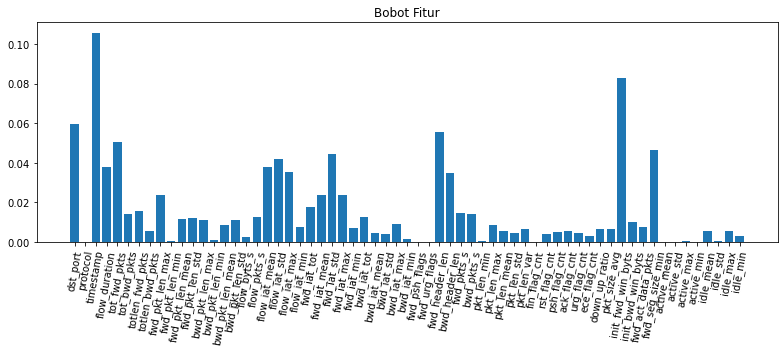

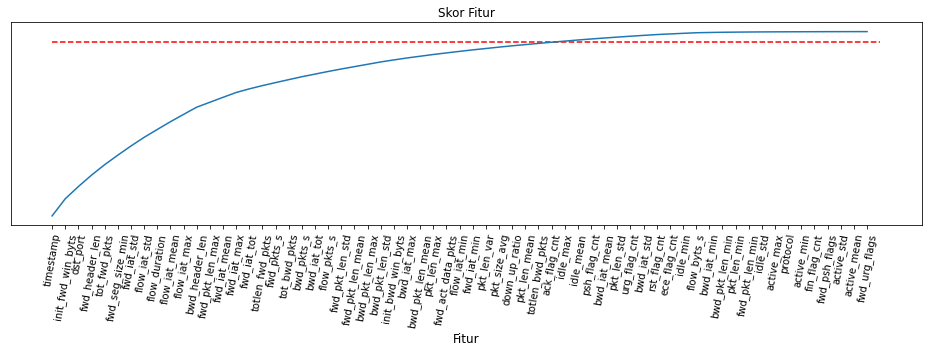

In [10]:
# Seleksi fitur dengan 'random forest' #
# ==================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 95

# vektor target
vektor_target = y_train['label']

# jumlah 'trees'
jumlah_trees = 100

# fitur terpilih dan fitur dihapus
klf = RandomForestClassifier(n_estimators=jumlah_trees, random_state=42, n_jobs=-1)
fit = klf.fit(X_train_norm, vektor_target)
fitur_dihapus_rf,fitur_terpilih_rf = fitur_terbaik (fit, persentase_skor, X_train_norm, 'rf')

# hapus fitur dengan skor terendah
X_train_rf = X_train_norm.drop(fitur_dihapus_rf, axis=1)
X_test_rf = X_test_norm.drop(fitur_dihapus_rf, axis=1)

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'random forest' : ", s_sf - m_sf)

In [11]:
# label aktual dan jumlah fitur #
# ============================= #

# label aktual biner kelas
y_aktual_biner = y_test['label_binary_code'].reset_index(drop=True)

# fitur dan jumlah fitur yang digunakan
print ('Fitur yang digunakan')
print ('====================')
print (list(X_train_rf.columns))
print ('')
print ('Jumlah fitur')
print ('============')
print (len(X_train_rf.columns),'fitur')

Fitur yang digunakan
['dst_port', 'timestamp', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_max', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_var', 'ack_flag_cnt', 'down_up_ratio', 'pkt_size_avg', 'init_fwd_win_byts', 'init_bwd_win_byts', 'fwd_act_data_pkts', 'fwd_seg_size_min']

Jumlah fitur
39 fitur


### 5.2. Hyperparameter tuning LSTM

In [12]:
# ubah dataset ke array
X_train_1 = X_train_rf.to_numpy()
X_test_1 = X_test_rf.to_numpy()

# ubah dataset ke array
y_train_1 = y_train['label_binary_code'].to_numpy()
y_test_1 = y_test['label_binary_code'].to_numpy()

# reshape ke bentuk 3 dimensi
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], 1, X_train_1.shape[1]))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], 1, X_test_1.shape[1]))

In [13]:
# Hyperparameter tuning LSTM #
# ========================== #

m_hyper = time.time()

# bangun model
model = KerasClassifier(build_fn=bangun_model, verbose=0)

# parameter yang digunakan untuk tuning
params={'batch_size':[256, 512, 1024, 2048], 
        'epochs':[10, 20, 30, 40],
        'unit':[16, 32, 48, 64],
        'dropout':[0.1, 0.2, 0.3, 0.4, 0.5],
        'learning_rate':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}

n_iter = 15
cv = 5

# tentukan f1 macro
f1_macro_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

lstm_grid = RandomizedSearchCV(estimator=model, param_distributions=params,
                               n_iter=n_iter, cv=cv, random_state=5, n_jobs=-1, verbose=10, scoring=f1_macro_scorer)

# terapkan random grid pada data latih
lstm_grid.fit(X_train_1, y_train_1, shuffle=False)

s_hyper = time.time()
print ("Lama waktu 'hyperparameter tuning' :", s_hyper - m_hyper)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Lama waktu 'hyperparameter tuning' : 19350.72541618347


In [14]:
# Hasil tuning parameter #
# ====================== #

# hasil
print ('F1 skor dan parameter terbaik')
print ('=============================')
print ('Nilai f1 skor terbaik : %s' % lstm_grid.best_score_)
print ('Parameter terbaik     : %s' % lstm_grid.best_params_)
test_5_lstm_new_params = pd.DataFrame(lstm_grid.cv_results_)

# simpan hasil hyperparameter LSTM
test_5_lstm_new_params.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_5_lstm_new_params.txt", index=False)

F1 skor dan parameter terbaik
Nilai f1 skor terbaik : 0.9966094330499399
Parameter terbaik     : {'unit': 48, 'learning_rate': 0.05, 'epochs': 30, 'dropout': 0.3, 'batch_size': 2048}


### 5.3. Parameter terbaik

In [16]:
# 5 hyperparameter terbaik #
# ======================== #

# hyperparameter terbaik
hyperparam_lstm = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_5_lstm_new_params.txt")

# mengurutkan parameter terbaik berdasarkan f1
hyperparam_lstm = hyperparam_lstm.sort_values("rank_test_score")

# menampilkan 5 hyperparameter terbaik
print ('5 Paramater terbaik berdasarkan f1')
print ('==================================')
param = hyperparam_lstm[['rank_test_score','params','mean_fit_time','mean_test_score']].reset_index(drop=True)
#param = param[['params']]
param.head(5)

5 Paramater terbaik berdasarkan f1


,rank_test_score,params,mean_fit_time,mean_test_score
0,1,"{'unit': 48, 'learning_rate': 0.05, 'epochs': 30, 'dropout': 0.3, 'batch_size': 2048}",1310.246364,0.996609
1,2,"{'unit': 32, 'learning_rate': 0.05, 'epochs': 40, 'dropout': 0.4, 'batch_size': 2048}",1146.278520,0.996581
2,3,"{'unit': 48, 'learning_rate': 0.01, 'epochs': 20, 'dropout': 0.2, 'batch_size': 1024}",1155.610809,0.996538
3,4,"{'unit': 16, 'learning_rate': 0.005, 'epochs': 30, 'dropout': 0.2, 'batch_size': 512}",1529.236391,0.996467
4,5,"{'unit': 32, 'learning_rate': 0.005, 'epochs': 20, 'dropout': 0.4, 'batch_size': 256}",1336.779373,0.996453


#### 5.3.1. Latih hyperparameter terbaik berdasarkan f1

In [17]:
param_lstm = param['params'][0]
param_lstm_1 = [eval(param_lstm)]       
param_lstm_1

[{'unit': 48,
  'learning_rate': 0.05,
  'epochs': 30,
  'dropout': 0.3,
  'batch_size': 2048}]

In [20]:
print ('|=======================================|')
print ("| Hyperparameter terbaik berdasarkan f1 |")
print ('|=======================================|')

# hyperparameter terbaik
param_terbaik = param_lstm_1

# latih model
y_f1 = latih_eval_lstm(param_terbaik, y_aktual_biner)

|=======================================|
| Hyperparameter terbaik berdasarkan f1 |
|=======================================|
Hyperparameter ke 1
Hyperparameter      : {'unit': 48, 'learning_rate': 0.05, 'epochs': 30, 'dropout': 0.3, 'batch_size': 2048}
Lama waktu latih    : 437.2475664615631
Lama waktu prediksi : 37.41769099235535
hasil 'accuracy'    : 0.9966522737210319
hasil 'f1-score'    : 0.9966522483674177



#### 5.3.2. Metrik evaluasi

|====================================|
| Matriks 'confusion' berdasarkan f1 |
|====================================|

Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9966522737210319
Precision : 0.9966673194149455
Recall    : 0.9966522737210319
F1-score  : 0.9966522483674177

metrik evaluasi :
              precision    recall  f1-score   support

           0   0.993934  0.999404  0.996661    548880
           1   0.999401  0.993900  0.996643    548880

    accuracy                       0.996652   1097760
   macro avg   0.996667  0.996652  0.996652   1097760
weighted avg   0.996667  0.996652  0.996652   1097760


matriks "confusion" :


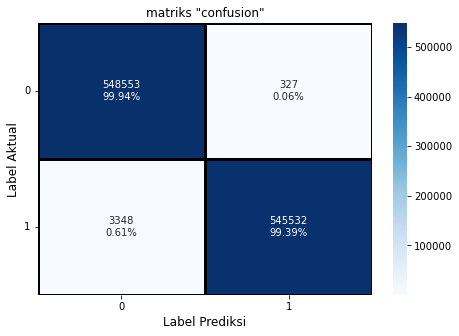

misklasifikasi kelas target:
   misklasifikasi   total  persentase_misklasifikasi(%)
1            3348  548880                      0.609969
0             327  548880                      0.059576
Lama waktu evaluasi model : 2.73394775390625


In [21]:
# Matriks 'confusion' dan misklasifikasi #
# ====================================== #

m_matriks = time.time()
print ('|====================================|')
print ("| Matriks 'confusion' berdasarkan f1 |")
print ('|====================================|')

# metrik evaluasi lapisan 1 berdasarkan f1
metrik (None, 1, y_aktual_biner, y_f1)

# misklasifikasi lapisan 1
misklasifikasi(y_aktual_biner, y_f1)

s_matriks = time.time()
print ('Lama waktu evaluasi model :', s_matriks - m_matriks)

## Test 6

### 6.1. Seleksi fitur random forest - 99%

In [28]:
m_test_2 = time.time()

Fitur yang dihapus
['idle_min', 'flow_byts_s', 'bwd_iat_min', 'bwd_pkt_len_min', 'pkt_len_min', 'fwd_pkt_len_min', 'idle_std', 'active_max', 'protocol', 'active_min', 'fin_flag_cnt', 'fwd_psh_flags', 'active_std', 'active_mean', 'fwd_urg_flags']


Fitur dengan skor terbaik
                Fitur  Persentase skor  jumlah persentase
1           timestamp        10.560959          10.560959
2   init_fwd_win_byts         8.300108          18.861067
3            dst_port         5.944268          24.805335
4      fwd_header_len         5.547529          30.352864
5        tot_fwd_pkts         5.066573          35.419437
6    fwd_seg_size_min         4.625303          40.044740
7         fwd_iat_std         4.451333          44.496073
8        flow_iat_std         4.185843          48.681915
9       flow_duration         3.814342          52.496257
10      flow_iat_mean         3.767701          56.263958
11       flow_iat_max         3.553180          59.817138
12     bwd_header_len         

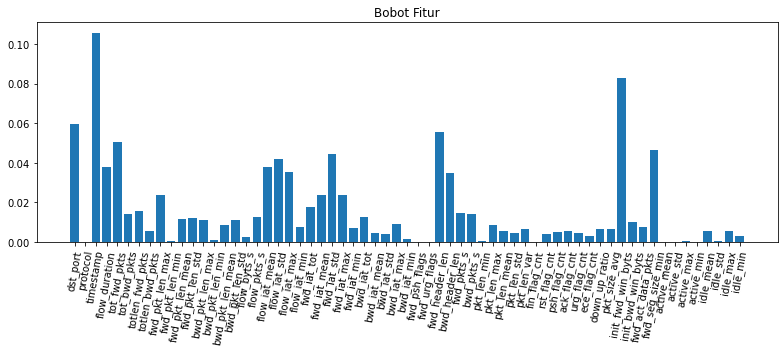

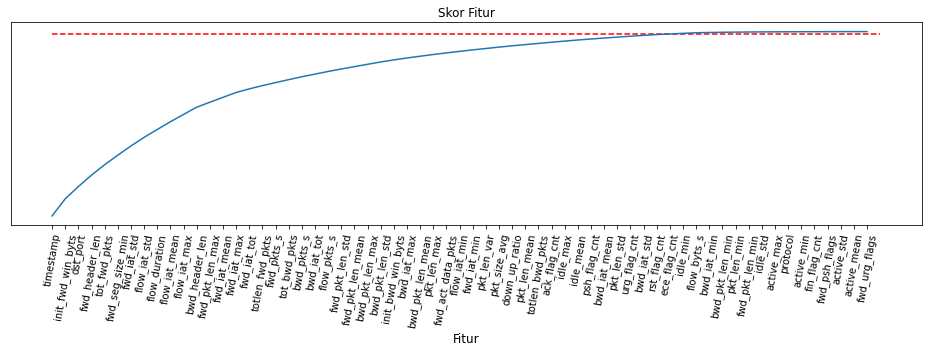

In [22]:
# Seleksi fitur dengan 'random forest' #
# ==================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 99

# vektor target
vektor_target = y_train['label']

# jumlah 'trees'
jumlah_trees = 100

# fitur terpilih dan fitur dihapus
klf = RandomForestClassifier(n_estimators=jumlah_trees, random_state=42, n_jobs=-1)
fit = klf.fit(X_train_norm, vektor_target)
fitur_dihapus_rf,fitur_terpilih_rf = fitur_terbaik (fit, persentase_skor, X_train_norm, 'rf')

# hapus fitur dengan skor terendah
X_train_rf = X_train_norm.drop(fitur_dihapus_rf, axis=1)
X_test_rf = X_test_norm.drop(fitur_dihapus_rf, axis=1)

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'random forest' : ", s_sf - m_sf)

In [23]:
# label aktual dan jumlah fitur #
# ============================= #

# label aktual biner kelas
y_aktual_biner = y_test['label_binary_code'].reset_index(drop=True)

# fitur dan jumlah fitur yang digunakan
print ('Fitur yang digunakan')
print ('====================')
print (list(X_train_rf.columns))
print ('')
print ('Jumlah fitur')
print ('============')
print (len(X_train_rf.columns),'fitur')

Fitur yang digunakan
['dst_port', 'timestamp', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg', 'init_fwd_win_byts', 'init_bwd_win_byts', 'fwd_act_data_pkts', 'fwd_seg_size_min', 'idle_mean', 'idle_max']

Jumlah fitur
48 fitur


In [20]:
# ubah dataset ke array
X_train_1 = X_train_rf.to_numpy()
X_test_1 = X_test_rf.to_numpy()

# ubah dataset ke array
y_train_1 = y_train['label_binary_code'].to_numpy()
y_test_1 = y_test['label_binary_code'].to_numpy()

# reshape ke bentuk 3 dimensi
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], 1, X_train_1.shape[1]))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], 1, X_test_1.shape[1]))

### 6.2. Hyperparameter tuning LSTM

In [21]:
# Hyperparameter tuning LSTM #
# ========================== #

m_hyper = time.time()

# bangun model
model = KerasClassifier(build_fn=bangun_model, verbose=0)

# parameter yang digunakan untuk tuning
params={'batch_size':[256, 512, 1024, 2048], 
        'epochs':[10, 20, 30, 40],
        'unit':[16, 32, 48, 64],
        'dropout':[0.1, 0.2, 0.3, 0.4, 0.5],
        'learning_rate':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}

n_iter = 15
cv = 5

# tentukan f1 macro
f1_macro_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

lstm_grid = RandomizedSearchCV(estimator=model, param_distributions=params,
                               n_iter=n_iter, cv=cv, random_state=6, n_jobs=6, verbose=10, scoring=f1_macro_scorer)

# terapkan random grid pada data latih
lstm_grid.fit(X_train_1, y_train_1, shuffle=False)

s_hyper = time.time()
print ("Lama waktu 'hyperparameter tuning' :", s_hyper - m_hyper)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Lama waktu 'hyperparameter tuning' : 17816.5378575325


In [22]:
# Hasil tuning parameter #
# ====================== #

# hasil
print ('F1 skor dan parameter terbaik')
print ('=============================')
print ('F1 skor terbaik   : %s' % lstm_grid.best_score_)
print ('Parameter terbaik : %s' % lstm_grid.best_params_)
test_6_lstm_new_params = pd.DataFrame(lstm_grid.cv_results_)

# simpan hasil hyperparameter LSTM
test_6_lstm_new_params.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_6_lstm_new_params.txt", index=False)

F1 skor dan parameter terbaik
F1 skor terbaik   : 0.9965898496494621
Parameter terbaik : {'unit': 32, 'learning_rate': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 1024}


### 6.3. Parameter terbaik

In [26]:
# 5 hyperparameter terbaik #
# ======================== #

# hyperparameter terbaik
hyperparam_lstm = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_6_lstm_new_params.txt")

# mengurutkan hyperparameter terbaik berdasarkan fi skor
hyperparam_lstm = hyperparam_lstm.sort_values("rank_test_score")

# menampilkan 5 hyperparameter terbaik
print ('5 hyperparameter terbaik berdasarkan f1 skor')
print ('============================================')
param = hyperparam_lstm[['rank_test_score','params','mean_fit_time','mean_test_score']].reset_index(drop=True)
#param = param[['params']]
param.head(5)

5 hyperparameter terbaik berdasarkan f1 skor


,rank_test_score,params,mean_fit_time,mean_test_score
0,1,"{'unit': 32, 'learning_rate': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 1024}",944.790496,0.996590
1,2,"{'unit': 48, 'learning_rate': 0.01, 'epochs': 10, 'dropout': 0.2, 'batch_size': 256}",704.792945,0.996563
2,3,"{'unit': 32, 'learning_rate': 0.05, 'epochs': 20, 'dropout': 0.3, 'batch_size': 2048}",496.742891,0.996561
3,4,"{'unit': 64, 'learning_rate': 0.01, 'epochs': 20, 'dropout': 0.5, 'batch_size': 512}",1225.301076,0.996541
4,5,"{'unit': 16, 'learning_rate': 0.01, 'epochs': 40, 'dropout': 0.3, 'batch_size': 2048}",698.195245,0.996539


#### 6.3.1. Latih hyperparameter terbaik berdasarkan f1

In [27]:
param_lstm = param['params'][0]
param_lstm_1 = [eval(param_lstm)]       
param_lstm_1

[{'unit': 32,
  'learning_rate': 0.01,
  'epochs': 30,
  'dropout': 0.2,
  'batch_size': 1024}]

In [28]:
print ('|=======================================|')
print ("| Hyperparameter terbaik berdasarkan f1 |")
print ('|=======================================|')

# hyperparameter terbaik
param_terbaik = param_lstm_1

# latih model
y_f1 = latih_eval_lstm(param_terbaik, y_aktual_biner)

|=======================================|
| Hyperparameter terbaik berdasarkan f1 |
|=======================================|
Hyperparameter ke 1
Hyperparameter      : {'unit': 32, 'learning_rate': 0.01, 'epochs': 30, 'dropout': 0.2, 'batch_size': 1024}
Lama waktu latih    : 420.5327067375183
Lama waktu prediksi : 32.286458253860474
hasil 'accuracy'    : 0.9966249453432444
hasil 'f1-score'    : 0.9966249237448959



#### 6.3.2. Metrik evaluasi

|====================================|
| Matriks 'confusion' berdasarkan f1 |
|====================================|

Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9966249453432444
Precision : 0.9966376580079914
Recall    : 0.9966249453432444
F1-score  : 0.9966249237448959

metrik evaluasi :
              precision    recall  f1-score   support

           0   0.994125  0.999155  0.996633    548880
           1   0.999150  0.994095  0.996616    548880

    accuracy                       0.996625   1097760
   macro avg   0.996638  0.996625  0.996625   1097760
weighted avg   0.996638  0.996625  0.996625   1097760


matriks "confusion" :


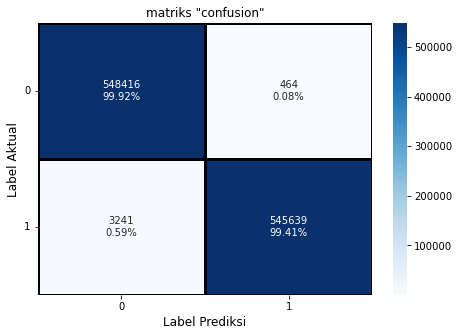

misklasifikasi kelas target:
   misklasifikasi   total  persentase_misklasifikasi(%)
1            3241  548880                      0.590475
0             464  548880                      0.084536
Lama waktu evaluasi model : 2.606508493423462


In [29]:
# Matriks 'confusion' dan misklasifikasi #
# ====================================== #

m_matriks = time.time()
print ('|====================================|')
print ("| Matriks 'confusion' berdasarkan f1 |")
print ('|====================================|')

# metrik evaluasi lapisan 1 berdasarkan f1
metrik (None, 1, y_aktual_biner, y_f1)

# misklasifikasi lapisan 1
misklasifikasi(y_aktual_biner, y_f1)

s_matriks = time.time()
print ('Lama waktu evaluasi model :', s_matriks - m_matriks)

In [43]:
s_test_2 = time.time()
print ('Lama waktu test 2 : ', s_test_2 - m_test_2)

Lama waktu test 2 :  9933.355307340622


In [44]:
s_total_waktu = time.time()
print ('Total waktu : ', s_total_waktu - m_total_waktu)

Total waktu :  33673.2426173687
